# Control de inclinación de una bicicleta mediante la actuación sobre la dirección
Documento basado en el contenido de Urbano Lugrís https://github.com/ulugris/bike



## Modelos dinámicos


### Modelo de Whipple
En lugar del modelo tan simplificado del péndulo invertido, podemos emplear un modelo un poco más complejo, llamado modelo de Whipple, que consta de 4 sólidos rígidos: el cuadro, el conjunto de la dirección (incluye horquilla delantera, manillar y todas las piezas que se mueven solidariamente con ellos), y las dos ruedas. Se asume que las ruedas tienen espesor nulo (ruedas de filo de cuchillo), y que tienen rodadura perfecta (no pueden deslizar, ni levantarse del suelo). 

![Modelo de Whipple](./images/whippleBike.png)

Si hacemos un proceso parecido al del modelo anterior, se pueden llegar a obtener las ecuaciones del movimiento de este sistema. El sistema completo cuenta con tres coordenadas relevantes: el avance longitudinal, el ángulo de inclinación, y el ángulo de dirección. La parte del avance no nos interesa para realizar el control lateral, así que nos vamos a centrar en la parte lateral, en la que el ángulo de inclinación y el ángulo de dirección están acoplados.  Linealizando esta parte de la dinámica lateral, se obtienen las siguiente expresión: 

$$
    \mathbf{M\ddot{q}} + v \mathbf{C}_1 \mathbf{\dot{q}} + \left[ g \mathbf{K}_0 + v^2 \mathbf{K}_2\right]\mathbf{q} = \mathbf{f}
$$

En donde $\mathbf{M}$ es la matriz de masas, $\mathbf{q}= \left[\phi, \delta \right]^\rm{T}$ es el vector de coordenadas del sistema, cuya primera coordenada, es el ángulo de roll, y la segunda, el ángulo de dirección (en este modelo $\delta$ es equivalente al ángulo $u$ empleado en el modelo de péndulo invertido), $\mathbf{\dot{q}}$ y $\mathbf{\ddot{q}}$ son sus derivadas primera y segunda, respectivamente, $v$ es la velocidad longitudinal de la bicicleta, $g$ es el valor de la aceleración de la gravedad, y las matrices $\mathbf{K}_0$, $\mathbf{C}_1$ y $\mathbf{K}_2$ son unas matrices que se comportan como matrices de rigidez y amortiguamiento. Por último, $\mathbf{f}$ es el vector de fuerzas directamente aplicadas sobre las coordenadas. Es decir, en este caso, serían el par de roll (que consideraremos nulo) y el par aplicado sobre la dirección. El valor de las matrices de coeficientes $\mathbf{M}$, $\mathbf{K}_0$, $\mathbf{C}_1$ y $\mathbf{K}_2$ se calculan en función de 25 parámetros de la bicicleta (dimensiones, ángulo de dirección, momentos de inercia, etc.). Las expresiones para calcular estos parámetros, así como la deducción de las ecuaciones linealizadas se pueden encontrar en [6]. Si empleamos los datos de la bicicleta empleada en ese mismo artículo, podemos obtener el siguinete modelo: 


#### Modelo de Whipple en forma *state-space*

Podemos manipular la ecuación anterior para ponerla en forma *state-space*. Para ello, cambiamos las variables de forma que podamos expresar el sistema original en forma de sistema de primer orden. Si, como en el caso anterior, llamamos $\mathbf{x}$ a nuestros estados, podemos decir que: 

$$ \mathbf{x}  = \begin{bmatrix}
\phi\\ \delta \\ \dot{\phi} 
\end{bmatrix} $$

Por lo tanto, 

$$ \mathbf{\dot{x}} = \begin{bmatrix}
\dot{\phi} \\ \dot{\delta} \\ \ddot{\phi} 
\end{bmatrix} $$

Recordando que la forma *state-space* que buscamos es la misma que en el caso anterior, con la forma siguiente: 

$$
    \begin{align}
        & \dot{\mathbf x}=\mathbf{Ax}+\mathbf{B}u \\
        & y = \mathbf{Cx} + Du
    \end{align}
$$

Roerdenando las ecuaciones linealizadas del movimiento, podemos escribir lo siguiente: 

$$
\begin{bmatrix} \mathbf{\dot{\phi}} \\ \mathbf{\dot{\delta}} \\ \mathbf{\ddot{\phi}} \end{bmatrix} = 
\begin{bmatrix} \mathbf{0}_{2\times 2} & \mathbf{I}_{2\times 1} \\ -\mathbf{M}^{-1}\left[v^2\mathbf{K}_2 +g\mathbf{K}_0 \right] & -\mathbf{M}^{-1}v\mathbf{C}_1 \end{bmatrix}
\begin{bmatrix} \mathbf{{\phi}} \\ \mathbf{{\delta}} \\ \mathbf{\dot{\phi}} \end{bmatrix} + 
\begin{bmatrix} 0 & 1 & 0 \end{bmatrix}^{\rm{T}}
\dot{\delta}
$$

En donde $T_{\delta}$ es el par aplicado a la dirección. Identificado términos en esta ecuación, ya se ve que esto se puede expresar como $\dot{\mathbf x}=\mathbf{Ax}+\mathbf{B}u $

Como la cantidad a controlar es el ángulo de roll, la ecuación de la salida (*output*) quedaría de la siguiente forma: 

$$
y = \begin{bmatrix} 1 &0 &0  \end{bmatrix}\mathbf{x} + \begin{bmatrix} 0 \end{bmatrix} u
$$

Así que, identificando términos, podemos ver que las matrices $\mathbf{C}$ y $\mathbf{D}$ resultan: 

$$ 
    \begin{align}
        &\mathbf{C} = \begin{bmatrix} 1 &0 &0  \end{bmatrix}\\
        &\mathbf{D} = \begin{bmatrix} 0 \end{bmatrix}
    \end{align}
$$
    
    

In [3]:
import numpy as np

v = 2 #Velocidad en m/s
g = 9.81  # Aceleración de la gravedad en m/s2
M = np.array([[3.23539172,0.21209065], [0.21209065,0.07431033]])
#Mostramos el contenido de la matriz de masas del sistema
print(M)
invM = np.linalg.inv(M) # Inverse of the mass matrix
#invM = invM[:1]
K0 = np.array([[-7.11818,-0.43652213],[-0.43652213,-0.13921987]])
print(K0)
K2 = np.array([[0.,6.87387868],[0.,0.4706314]])
print(K2)
C1 = np.array([[0.,3.56526808],[-0.31016046,0.3787769]])
print(C1)

# Formatting as state-space
A = np.block([[np.zeros((2,2)), np.eye(2)], [-invM@(v**2*K2+g*K0), -v*invM@C1]])
print(A)
A = A[0:3,0:3]
print(A)
B = np.array([[0.0], [1.0], [0.0]])
C = np.array([1.0, 0.0, 0.0])
D = np.array([0.0])



[[3.23539172 0.21209065]
 [0.21209065 0.07431033]]
[[-7.11818    -0.43652213]
 [-0.43652213 -0.13921987]]
[[0.         6.87387868]
 [0.         0.4706314 ]]
[[ 0.          3.56526808]
 [-0.31016046  0.3787769 ]]
[[ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]
 [21.90338199 -8.26532049 -0.6731676  -1.88907755]
 [-4.88788609 16.63589059 10.26900934 -4.80280621]]
[[ 0.          0.          1.        ]
 [ 0.          0.          0.        ]
 [21.90338199 -8.26532049 -0.6731676 ]]


# Diseño del controlador

## Estabilidad del sistema

En la bibliografía sobre Control es frecuente referirse al sistema que queremos controlar, de modo general, como *planta*. Cuando no hay realimentación, el sistema se conoce como *planta en lazo abierto*. Si consideramos el sistema libre, sin introducir ningún *input*, resultará una ecuación diferencial de la forma:

$$
    \dot{\mathbf x} = \mathbf A\mathbf x
$$

Se dice que un sistema es *asintóticamente estable* si, para unas condiciones iniciales cualesquiera, el vector de estados $\mathbf x$ tiende a cero cuando el tiempo tiende a infinito. Se puede demostrar que la solución de un sistema de este tipo es estable cuando todos los autovalores de $\mathbf A$ tienen parte real negativa. Como se puede ver, nuestro sistema no es estable, ya que tiene un autovalor con parte real positiva:

In [4]:
# Comprobamos los autovalores de 'A'
print(np.real(np.linalg.eig(A)[0]))

[ 4.35560872 -5.02877632  0.        ]


## Primera aproximación: regulador PID

Cuando no se dispone de un modelo dinámico del sistema, la forma más simple de estabilizarlo es utilizando un regulador PID. En este caso, se podría utilizar un PID en el que la entrada fuese el error entre el ángulo de inclinación deseado y el real, y la salida el ángulo de dirección o el par aplicado a la dirección. En general, lo que hay que hacer para estabilizar una bicicleta es girar el manillar en la dirección de la caída ([*steer into the fall*](https://youtu.be/o7nSQ2ycGX4)).

El problema de utilizar este tipo de controladores es que suelen ser difíciles de ajustar, por lo que, si es posible, es mejor recurrir a métodos más avanzados, como la realimentación de estados, que se describe a continuación.


## Estabilización mediante realimentación de estados

La realimentación de estados se basa en definir la entrada del sistema $u$ como una realimentación negativa del estado, de la siguiente forma:

$$
    u = -\mathbf K\mathbf x
$$

Con este tipo de realimentación, se puede determinar de forma analítica una matriz de ganancias $\mathbf K$ que estabilice el sistema, es decir, que haga que todos los autovalores sean negativos. Para verlo más claramente, se puede introducir la realimentación en las ecuaciones del sistema:

$$
    \dot{\mathbf x} = \mathbf{Ax} - \mathbf{BKx} = \left(\mathbf A - \mathbf{BK}\right)\mathbf x
$$

Se observa que, ahora, la estabilidad del sistema la determinan los autovalores de $\mathbf A - \mathbf{BK}$. Esto significa que se puede alterar la dinámica del sistema a conveniencia, ajustando la matriz $\mathbf K$ para colocar los autovalores donde nos interese. Este método de control se puede esquematizar de la forma siguiente:

![Diagrama de bloques](./images/Figure3.png)

## Regulador cuadrático lineal (LQR)

El esquema de control de realimentación de estados deja abierta una decisión complicada al diseñador: ¿dónde colocar los autovalores del sistema? Existen diversos métodos descritos en la bibliografía, dedicados a determinar dónde se deben colocar los autovalores para conseguir que la respuesta del sistema presente unas características determinadas. Estas técnicas se denominan *asignación de polos* o *pole placement*.

En nuestro proyecto, vamos a utilizar un método un poco más elaborado, pero a la vez sencillo de utilizar: el LQR (*Linear Quadratic Regulator*). El LQR no es más que otro método para calcular la matriz $\mathbf K$, pero en lugar de tener que decidir dónde colocamos los polos del sistema, lo que hacemos es buscar el valor único de $\mathbf K$ que minimiza la siguiente función:

$$
    J = \int_0^\infty\left(\mathbf x^T\mathbf Q\mathbf x + Ru^2\right)dt
$$

Esta función (expresada aquí en forma específica para un sistema con un solo *inupt*) combina los valores cuadráticos, integrados a lo largo del tiempo, de las dos magnitudes que queremos minimizar: el error en los estados y la magnitud de la entrada de control. Cada término va ponderado por una matriz de pesos, $\mathbf Q$ para los estados y $R$ para el *input*, de modo que podemos decidir qué variables queremos penalizar más en el controlador. Por ejemplo, asignar un valor elevado al elemento $Q_{ii}$ de la diagonal de $\mathbf Q$ hará que los errores en el estado $x_i$ sean fuertemente penalizados en la función objetivo $J$, así que el controlador se esforzará en manternerlos bajos. Por el contrario, si se hace lo mismo con $R$, se indica al controlador que debe utilizar lo menos posible el actuador correspondiente al *input* $u$.

Modificando los elementos de $\mathbf Q$ y $R$ se puede ajustar el comportamiento del controlador a nuestros requerimientos, dando mayor relevancia al error en los estados o al esfuerzo de control. Lo primero puede ser importante si en algún estado es crítico mantener errores bajos, y lo segundo, por ejemplo, si es prioritario obtener una alta eficiencia energética, aunque sea al coste de menor precisión en el control. En nuestro caso, se podría utilizar para evitar que el controlador use ángulos de dirección demasiado grandes.

Una vez dererminadas las matrices de pesos, la función `lqr` del módulo de control de Python resuelve el problema de optimización y nos devuelve directamente la matriz de ganancias $\mathbf K$ que minimiza la función $J$:

In [5]:
from control import ss, lqr, ss2tf, minreal, forced_response

sys = ss(A, B, C, D)

Q = np.eye(3) # Aproximación incial para 'Q'
Q[0, 0] = 100 # Ajustamos peso del ángulo 'phi'
R = 1 # Peso del par de dirección 'u'
K = lqr(sys, Q, R)[0]
"Mostramos el valor de K"
print(K)


[[-40.88312642  11.52360588  -7.97267889]]


Para evaluar el comportamiento del regulador, se simula el comportamiento del sistema cuando partimos de un estado inicial fuera de equilibrio. Por ejemplo, colocamos la moto con un ángulo inicial $\phi_0$ de 20º, mientras circula en línea recta a la velocidad prefijada $v$ (10 m/s), de modo que el controlador generará un movimiento de dirección que la estabilice en vertical.

La entrada de referencia $r$ que se ve en el diagrama del controlador se dejará a cero (se explicará más adelante para qué sirve esta entrada). Como ejercicio, es interesante comprobar cómo varía la repuesta al modificar los pesos del LQR:

In [6]:
%%capture
from matplotlib.animation import FuncAnimation
import plotfunctions as pf

In [7]:
# Ensamblamos el sistema en lazo cerrado
clsys = ss(A - B@K, B, C, D)


tf = 10.00         # Duración de la simulación en segundos
dt = 0.01         # Paso de tiempo de simulación en segundos

# Simulamos respuesta para ángulo incial de 20 grados
t = np.arange(0, tf, dt)
r = np.zeros(t.shape)

T, Y, X = forced_response(clsys, t, r, X0=[np.radians(20), 0, 0], return_x=True)

#pf.plot_response(T, X)


Como se ve, el ángulo $\varphi$ converge rápidamente a cero, estabilizando el sistema.

Podemos verificar que, al aplicar la realimentación, todos los autovalores del sistema tienen ahora parte real negativa:

In [8]:
print(np.real(np.linalg.eig(A - B@K)[0]))

[-3.17478983 -3.17478983 -5.84719381]


A continuación se muestra una animación con el movimiento resultante:

In [9]:
h = 1.0 # This value is only used for graphical purposes
#FuncAnimation(pf.fg1, pf.anim, init_func=pf.init, frames=len(T), fargs=(X[[0, 1]], dt, h), interval=dt*1000, blit=True)


## Control de la inclinación

Cuando se aplica realimentación de estados, el controlador resultante siempre tratará de llevarlos todos al equilibrio, y eso es lo que se conoce como *regulador*. Hasta ahora, esto nos ha servido para estabilizar el sistema, manteniéndolo equilibrado en vertical. Si lo que queremos es asignar a algún *output* un valor arbitrario, hay que convertir nuestro regulador en un *servomecanismo*. El objetivo ahora es conseguir que el *output* (en nuestro caso el ángulo de inclinación $\varphi$) siga a un valor de referencia $r$, en lugar de converger hacia cero. De este modo, podremos controlar la dirección de la moto sin perder la estabilidad, ya que controlar el ángulo de inclinación implica controlar indirectamente el radio de curvatura de la trayectoria.

Antes de explicar cómo se consigue esto, es importante introducir un nuevo concepto: el *tipo* de sistema o planta. Por definición, una planta es de tipo $N$ cuando, al representarla como un sistema con realimentación unitaria (como el que se muestra en la figura), el término de grado más bajo del denominador de la función de transferencia $G$ es de grado $N$.

![Realimentación unitaria](./images/Figure4.png)

Es decir, si la función de transferencia en lazo abierto $G$ se escribe en la forma:

$$
    G(s) = \frac{K\left(T_as + 1\right)\left(T_bs + 1\right)\cdots\left(T_ms + 1\right)}
    {s^N\left(T_1s + 1\right)\left(T_2s + 1\right)\cdots\left(T_ps + 1\right)}
$$

el tipo de sistema corresponderá al exponente $N$ que aparece en el denominador. El tipo de un sistema determina su error de seguimiento $e$ en régimen permanente para distintos tipos de entrada. Por ejemplo, en un sistema tipo 1, el error tenderá a cero para una entrada escalón, a un valor finito para una entrada rampa, y a infinito para una entrada cuadrática o de orden superior. En cambio, un sistema tipo 0 ya mostrará un error finito en régimen permanente para una entrada escalón, y será inestable frente a una entrada rampa o superior.

Para saber el tipo de nuestro sistema, primero tenemos que representarlo según la estructura de la figura. La función de transferencia $H$ del sistema completo, entre la entrada $r$ y la salida $y$, se puede obtener sustituyendo el error de seguimiento $e$ por su valor $r - y$:

$$
    y = G\left(r - y\right) \implies H(s) = \frac{y}{r} = \frac{G}{1 + G}
$$

Entonces, se puede hacer el cambio inverso para expresar cualquier sistema con función de transferencia $H$ como sistema con realimentación unitaria:

$$
    G(s) = \frac{H}{1 - H}
$$

Comprobamos el tipo de nuestro sistema, incluyendo la realimentación, cuando consideramos que nuestro único *output* es la inclinación. La función `ss2tf` devuelve la función de transferencia $H$ de un sistema *state-space*, y `minreal` (*minimal realization*) cancela los factores comunes del numerador y el denominador:

In [10]:
# Función de transferencia del sistema con realimentación
H = ss2tf(clsys)

# Calculamos G para transformar en sistema con realimentación unitaria
minreal(H/(1 - H))

3 states have been removed from the model


TransferFunction(array([-8.26532049]), array([ 1.        , 12.19677347, 51.75068225, 93.77152156]))

Mirando el denominador, se ve claramente que nuestro sistema realimentado es de tipo 0. Eso significa que, para una entrada escalón, la salida $\varphi$ nunca alcanzará el valor de referencia $r$ en régimen permanente. Si queremos controlar la inclinación correctamente, tendremos que convertir el sistema en uno de tipo 1.

## Servomecanismo tipo 1 con integrador en la entrada

El problema de usar precompensación es que la respuesta es muy sensible a errores en los parámetros del sistema. Cualquier desviación en el valor de $\bar N$ hará que el sistema vuelva a ser de tipo 0, y por lo tanto tenga error en régimen permanente. La manera de resolver esto de forma más robusta es añadir a la entrada un integrador, en lugar de una simple ganancia:

![Diagrama con integral](./images/Figure6.png)

Para utilizar este esquema de control, hay que aumentar el sistema añadiéndole un estado adicional $\xi$, que será la integral del error de seguimiento $r - y$. Por lo tanto, su derivada es:

$$
    \dot\xi = r - y = r - \left(\mathbf{Cx} + Du\right)
$$

y la entrada $u$ pasa a ser ahora:

$$
    u = -\mathbf K \mathbf x + k_I\xi
$$

La ecuación completa de la dinámica del sistema aumentado, sin incluir la realimentación, se puede escribir como:

$$
    \begin{bmatrix} \dot{\mathbf x} \\ \dot\xi \end{bmatrix} = 
    \begin{bmatrix} \mathbf A && \mathbf 0 \\ -\mathbf C && 0 \end{bmatrix}
    \begin{bmatrix} \mathbf{x} \\ \xi\end{bmatrix} + 
    \begin{bmatrix} \mathbf B \\ -D \end{bmatrix}u + 
    \begin{bmatrix} \mathbf 0 \\ 1 \end{bmatrix}r
$$

Estudiaremos la respuesta de este sistema a una entrada escalón, cuando el tiempo tiende a infinito. Para ello, definiremos las siguientes magnitudes:

$$
    \mathbf e = \begin{bmatrix} \mathbf{x} - \mathbf{x}_\infty \\ \xi - \xi_\infty \end{bmatrix} \qquad
    u_e = u - u_\infty
$$

que representan las desviaciones del estado y la entrada respecto sus propios valores en régimen permanente. Como $r$ es un escalón, su valor es siempre el mismo para $t>0$, de forma que podemos escribir la dinámica del error como:

$$
    \dot{\mathbf e} = 
    \begin{bmatrix} \mathbf A && \mathbf 0 \\ -\mathbf C && 0 \end{bmatrix}
    \mathbf e + 
    \begin{bmatrix} \mathbf B \\ -D \end{bmatrix}u_e = \hat{\mathbf A}\mathbf e + \hat{\mathbf B}u_e
$$

Se puede observar que, de forma análoga a lo que ocurría al principio, tenemos un sistema en forma *state-space* cuyos estados tienen que converger asintóticamente a cero. Eso quiere decir que existirán unas ganancias de realimentación $\hat{\mathbf K}$ que estabilicen el sistema:

$$
    \hat{\mathbf K} = \begin{bmatrix} \mathbf K && -k_I \end{bmatrix}
$$

Estas ganancias se pueden calcular, como antes, utilizando el algoritmo LQR, sabiendo que ahora tenemos cinco estados, ya que el último corresponde a la integral del error de seguimiento:

In [19]:
from control import ss, lqr, ss2tf, minreal, forced_response
import numpy as np

v = 2 #Velocidad en m/s

g = 9.81  # Aceleración de la gravedad en m/s2

M = np.array([[4.08597824,0.22498754], [0.22498754,0.07474757]])

invM = np.linalg.inv(M) # inverse of the mass matrix

K0 = np.array([[-7.70539504,-0.3469105],[-0.3469105,-0.11064006]])

K2 = np.array([[0., 7.31520562],[0, 0.36611993]])

C1 = np.array([[ 0., 3.91165444],[-0.23658889, 0.27557226]])


# Formatting as state-space
A = np.block([[np.zeros((2,2)), np.eye(2)], [-invM@(v**2*K2+g*K0), -v*invM@C1]])
A = A[0:3,0:3]
B = np.array([[0.0], [1.0], [0.0]])
C = np.array([1.0, 0.0, 0.0])
D = np.array([0.0])




# Ecuaciones del sistema con los errores como estados
# Se añade la integral del error en ángulo como quinto estado
Ah = np.block([[A, np.zeros((3, 1))], [-C, 0]])
Bh = np.block([[B], [-D]])

# Controlador LQR para la dinámica del error
Q = np.zeros((4,4))  # Aproximación inicial para 'Q'
Q[0, 0] = 10  # Ajustamos peso del ángulo 'phi' ángulo de inclinación
Q[1, 1] = 1 # Ajustamos peso del ángulo de dirección
Q[2, 2] = 0 # Velocidad de ángulo de inclinación
Q[3, 3] = 100  # Peso de la integral del error en velocidad 'xi'
R = 1 # Peso del ángulo de dirección 'u', meterle 50 en la segunda simulación IIoT


# La función 'LQR' también admite usar sólo las matrices A y B
Kh = lqr(Ah, Bh, Q, R)[0]
print(Kh)
Kn = Kh[0, :-1]
print(Kn)
Ki = -Kh[0, -1]
print(Ki)

[[-42.00608109  11.2513673   -8.66057382  10.        ]]
[-42.00608109  11.2513673   -8.66057382]
-9.99999999999802


Para simular el sistema, utilizaremos un modelo aumentado de la siguiente forma, que se obtiene al sustituir en la ecuación del sistema el valor de $u$:

$$
    \begin{bmatrix} \dot{\mathbf x} \\ \dot\xi \end{bmatrix} = 
    \begin{bmatrix} \mathbf A - \mathbf{BK} && \mathbf Bk_I \\ D\mathbf K - \mathbf C && -Dk_I \end{bmatrix}
    \begin{bmatrix} \mathbf{x} \\ \xi\end{bmatrix} + 
    \begin{bmatrix} \mathbf 0 \\ 1 \end{bmatrix}r
$$

Antes de simular, verificamos que este sistema es de tipo 1:

In [20]:
# Sistema en lazo cerrado con las ganancias obtenidas
An = np.block([[A - B*Kn, B*Ki], [D*Kn - C, -D*Ki]])
Bn = [[0], [0], [0], [1]]
Cn = [1, 0, 0, 0]
Dn = 0

clisysint = ss(An, Bn, Cn, Dn)

# Función de transferencia del sistema con realimentación
H = ss2tf(clisysint)

# Calculamos G(s) para sistema con realimentación unitaria
minreal(H/(1 - H))

4 states have been removed from the model


TransferFunction(array([72.50862864]), array([ 1.        , 11.6691857 , 48.32758921, 88.8908107 ,  0.        ]))

Para comprobar que este método es mucho más robusto que la precompensación, se puede hacer una prueba sencilla. En el modelo con precompensación, si antes de ensamblar el sistema *state-space* se simula un error en los parámetros del modelo multiplicando $\bar N$ por un factor, por ejemplo 0.9, se verá que el sistema pasa a ser tipo 0, incluso con valores del factor muy cercanos a la unidad. En cambio, si se hace lo mismo con $k_I$, se observa que el término de grado 0 del denominador se mantiene cercano a cero para cualquier valor de $k_I$.

A continuación se muestra gráficamente la respuesta, comparándola con la obtenida usando precompensación (en línea de puntos). Igual que antes, es interesante probar diferentes pesos en el LQR, para ver cómo varía el comportamiento del sistema.

In [21]:
# Respuesta con misma entrada que en el modelo con precompensación
#T, Y, Xn = forced_response(clisysint, t, r,return_x=True)

#pf.plot_response(T, Xn, X)

Antes de implementar el controlador, hay que asegurarse de que no estamos saturando el actuador:

In [22]:
#pf.plot_steering_torque(T, (Ki*Xn[3, :] - Kn@Xn[:3, :]).T)

Vemos que los pares aplicados en la dirección se mantienen dentro de valores mucho más realistas. Como siempre, es interesante ver cómo afectan los pesos del LQR, buscando un equilibrio entre una respuesta rápida (pero más brusca) y un comportamiento suave (pero más lento).

A continuación se muestra una animación del nuevo movimiento:

In [23]:
#FuncAnimation(pf.fg1, pf.anim, init_func=pf.init, frames=len(T), fargs=(Xn[[0, 2]], dt, h), interval=dt*1000, blit=True)

Como todo es correcto, ya podemos utilizar las ganancias para la implementación física del controlador. Se pueden copiar y pegar directamente en un sketch de Arduino, siendo ahora el par de dirección $u= -\mathbf{Kx} + k_I\xi$. Esto significa que, además de los estados anteriores, habrá que ir calculando la integral del error de inclinación, que no es más que ir acumulando en una variable dicho error $\xi = r - \phi$, multiplicado por el paso de tiempo.

In [24]:
print('const float K1 =%10.6f;  // Ganancia phi'      % Kn[0])
print('const float K2 =%10.6f;  // Ganancia delta'    % Kn[1])
print('const float K3 =%10.6f;  // Ganancia phip'     % Kn[2])
print('const float Ki =%10.6f;  // Ganancia integral' % Ki)

const float K1 =-42.006081;  // Ganancia phi
const float K2 = 11.251367;  // Ganancia delta
const float K3 = -8.660574;  // Ganancia phip
const float Ki =-10.000000;  // Ganancia integral


## Simulación del sistema completo con el controlador
Se reconstruye el sistema original, y se emplea el controlador obtenido para simular el modelo de Wipple completo, usando un integrador Forward Euler, con un paso de tiempo de 1 ms. A su vez, se comprueba también como evoluciona el par requerido a lo largo de la simulación y la potencia del motor necesaria.


Se introducen variaciones en los parámetros para ver como de robusto es el controlador:


Se comprueba el ángulo de inclinación durante la maniobra


Text(0, 0.5, '$\\phi$ (deg)')

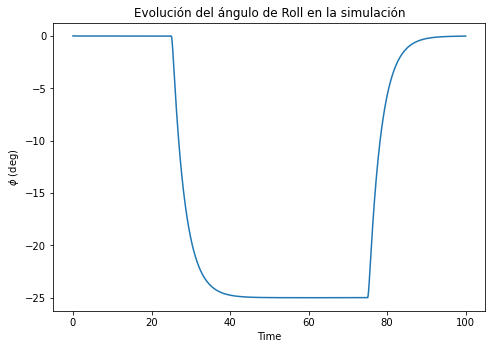

In [25]:
from matplotlib import pyplot as plt
import numpy as np

v = 4 #Velocidad en m/s
g = 9.81  # Aceleración de la gravedad en m/s2

#M = np.array([[4.08597824,0.22498754], [0.22498754,0.07474757]])
invM = np.linalg.inv(M) # inverse of the mass matrix
#K0 = np.array([[-7.70539504,-0.3469105],[-0.3469105,-0.11064006]])
#K2 = np.array([[0., 7.31520562],[0, 0.36611993]])
#C1 = np.array([[ 0., 3.91165444],[-0.23658889, 0.27557226]])

# Formatting as state-space
A = np.block([[np.zeros((2,2)), np.eye(2)], [-invM@(v**2*K2+g*K0), -v*invM@C1]])
B = np.array([[0.0], [0.0], [0.0], [1/M[1,1]]])
C = np.array([1.0, 0.0, 0.0, 0.0])
D = np.array([0.0])


dt = 0.001
tfin = 100
timevec = np.arange(0,tfin,dt)
L = timevec.shape[0] # Size of the time vector
ref = np.zeros([L,1]) #Referencias de cada paso, vector columna con un número de filas igual a L.
ref[L//4:-L//4] = -25*(np.pi/180)

# Condiciones iniciales

x = np.zeros((4,L)) # Vector para guardar los estados
u_torque = np.zeros((1,L))
x[1,0] = 0.01 # Perturbación inicial en este caso de velocidad de ángulo de Roll
xi = 0
torque_max = 6 # Par máximo del motor(N·m) en caso de que se alcanzase
k = 10

for i in range(1,L):
    xi = xi+ (ref[i]-x[0,i-1])*dt # Error integrado
    u_vel = -Kn@x[0:3,i-1] + Ki*xi # Entrada en velocidad
    u_torque[0,i-1] = k*(u_vel-x[3,i-1])# Controlador proporcional
    xp = A@x[:,i-1:i]+B*u_torque[0,i-1] # Se calcula la derivada de los estados a través de la primera ecuación del
                                 # state-space    
    x[:,i:i+1] = x[:,i-1:i] + xp*dt # Forward Euler como integrador
    
# Se dibuja la respuesta en el tiempo de simulación    

t = timevec
y = x[0,:]*(180/np.pi)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(t,y)
ax.set_title("Evolución del ángulo de Roll en la simulación")
ax.set_xlabel('Time')
ax.set_ylabel(r'$\phi$ (deg)')
    

Se comprueba como varía el ángulo de dirección a lo largo de la maniobra:

Text(0, 0.5, '$\\delta$ ($\\degree$)')

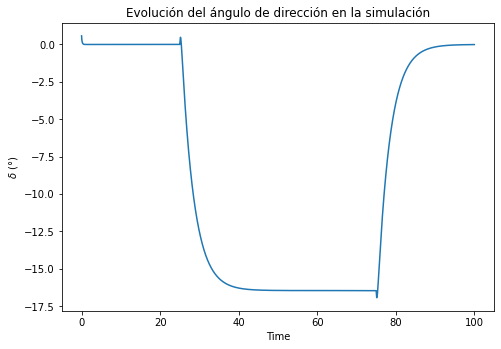

In [26]:
t = timevec
y = x[1,:]*(180/np.pi)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(t,y)
ax.set_title("Evolución del ángulo de dirección en la simulación")
ax.set_xlabel('Time')
ax.set_ylabel(r'$\delta$ ($\degree$)')
    

Se comprueba como son las velocidades de ángulo de dirección a lo largo de la maniobra:

Text(0, 0.5, '$\\dot{\\delta}$($\\degree$/s)')

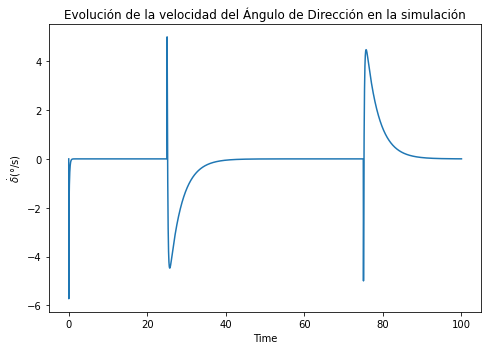

In [27]:
from matplotlib import pyplot as plt
import numpy as np
import numpy as np
t = timevec
y = x[3,:]*(180/np.pi)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(t,y)
ax.set_title("Evolución de la velocidad del Ángulo de Dirección en la simulación")
ax.set_xlabel('Time')
ax.set_ylabel('$\dot{\delta}$($\degree$/s)')

Se comprueba el valor de las entradas calculadas por el controlador a lo largo de la maniobra:

In [28]:
from matplotlib import pyplot as plt
import numpy as np
t = timevec
y = u_vel[0,:]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(t,y)
ax.set_title("Evolución de la entrada calculada por el controlador en la simulación")
ax.set_xlabel('Time')
ax.set_ylabel('$\dot{\delta}$($\degree$/s)')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Se comprueba el par necesario a lo largo de la maniobra:

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
t = timevec
y = u_torque[0,:]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(t,y)
ax.set_title("Evolución del par en la simulación")
ax.set_xlabel('Time')
ax.set_ylabel('T (Nm)')

Se comprueba la potencia que el motor debe proporcinar a lo largo de la maniobra:

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
t = timevec
# Potencia necesaria a lo largo de la simulación
y = abs(x[3,:]*u_torque[0,:])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(t,y)
ax.set_title("Evolución de la potencia en la simulación")
ax.set_xlabel('Time')
ax.set_ylabel('P (W)')

Se ajuntan las curvas de Velocidad de ángulo de dirección, Par motor y Potencia del motor juntas.

<Figure size 144x144 with 0 Axes>

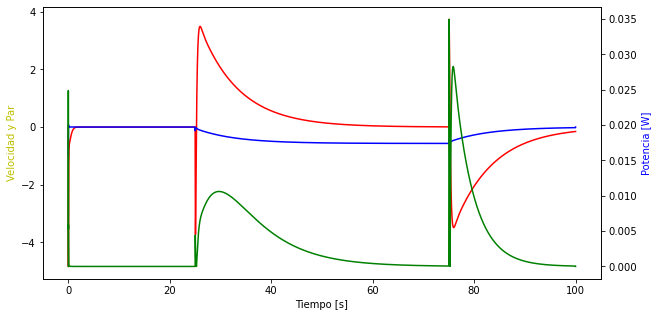

In [72]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(2,2))


t = timevec


fig, ax1 = plt.subplots(figsize=(10, 5))

ax2 = ax1.twinx()
ax1.plot(t, x[3,:]*(180/np.pi), 'r-')
ax1.plot(t, u_torque[0,:], 'b-')
ax2.plot(t,abs(x[3,:]*u_torque[0,:]),'g-')

ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('Velocidad y Par', color='y')
ax2.set_ylabel('Potencia [W]', color='b')

plt.show()



## Funcionamiento a diferentes velocidades

Todo lo que se ha hecho hasta ahora ha implicado considerar la velocidad de avance $v$ como un parámetro más del modelo, como la masa o el momento de inercia. Eso quiere decir que las ganancias del controlador que obtengamos estarán optimizadas para funcionar a esa velocidad. En la práctica, lo más probable es que el controlador funcione correctamente en un rango determinado de velocidades, pero si nos alejamos mucho de $v$, empezará a fallar. Una forma de comprobar la sensibilidad del sistema es calcular las ganancias para diferentes velocidades: cuanto menos varíen las ganancias al cambiar la velocidad, más robusto será el controlador.

Si la variabilidad de ganancias es alta y se quiere un controlador que pueda funcionar a diferentes velocidades, habrá que calcular varios vectores de ganancias $\mathbf K_i$, de modo que cada uno tendrá validez en un rango de velocidades. Incluso se puede estudiar la variación de las ganancias en función de la velocidad, e implementar alguna estrategia de interpolación.

# Bibliografía
[1] Ogata, K. *Modern Control Engineering, 5th Ed.*, Pearson, 2010   
[2] Williams II, R. L., Lawrence, D. A. *Linear State-Space Control Systems*, John Wiley & Sons, 2007  
[3] Hespanha, J. P. *Linear Systems Theory, 2nd Ed.*, Princeton University Press, 2018  
[4] Åström, K. J., Murray, R. M., [*Feedback Systems*](http://www.cds.caltech.edu/~murray/amwiki/index.php), Princeton University Press, 2008  
[5] Messner, B. et al. [*Control Tutorials for Matlab and Simulink*](http://ctms.engin.umich.edu)  
[6] Meijaard, J.P. et al. *Linearized dynamics equations for the balance and steer of a bicycle: a benchmark and review*. Proc. R. Soc. A. 463 1955–1982, 2007. 

# Acerca de este documento
Autor: Urbano Lugrís Armesto  

Adaptado por Emilio Sanjurjo, Pablo Rubial, Eduardo Sobrino y Santiago Blanco

[Laboratorio de Ingeniería Mecánica](http://lim.ii.udc.es/)  
[Escuela Politécnica Superior](https://eps.udc.es/)  
[Universidad de A Coruña](https://www.udc.es/)  

Este documento pertenece a la asignaturas *Proyecto Interdisciplinar I* y *Proyecto Interdisciplinar II*, de cuarto curso de los Grados en Ingeniería Mecánica e Ingeniería en Tecnologías Industriales, impartidos en la Escuela Politécnica Superior de la Universidad de A Coruña.